In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1.7.2 Finding concepts in texts - Hierarchical Dirichlet Process.


In [61]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import gensim
import networkx as nx
import pandas as pd

wordnet = nltk.WordNetLemmatizer()
stemmer = nltk.SnowballStemmer('english')
stoplist = stopwords.words('english')


In [3]:
text_root = '../data/EmbryoProjectTexts/files'
zotero_export_path = '../data/EmbryoProjectTexts'

corpus = nltk.corpus.PlaintextCorpusReader(text_root, 'https.+')
metadata = zotero.read(zotero_export_path, index_by='link', follow_links=False)

In [4]:
def normalize_token(token):
    """
    Convert token to lowercase, and stem using the Porter algorithm.

    Parameters
    ----------
    token : str

    Returns
    -------
    token : str
    """
    return wordnet.lemmatize(token.lower())

def filter_token(token):
    """
    Evaluate whether or not to retain ``token``.

    Parameters
    ----------
    token : str

    Returns
    -------
    keep : bool
    """
    token = token.lower()
    return token not in stoplist and token.isalpha() and len(token) > 2

We will represent our documents as a list of lists. Each sub-list contains tokens in the document.

In [5]:
documents=[[normalize_token(token) 
            for token in corpus.words(fileids=[fileid])
            if filter_token(token)]
           for fileid in corpus.fileids()]

In [55]:
years = [metadata[fileid].date for fileid in corpus.fileids()]

## Further filtering

LDA in Python is a bit computationally expensive, so anything we can do to cut down on "noise" will help. Let's take a look at wordcounts and documentcounts to see whether we can narrow in on more useful terms.

In [6]:
wordcounts = nltk.FreqDist([token for document in documents for token in document])

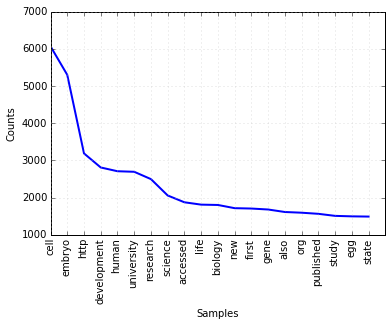

In [7]:
wordcounts.plot(20)

In [8]:
documentcounts = nltk.FreqDist([token for document in documents for token in set(document)])

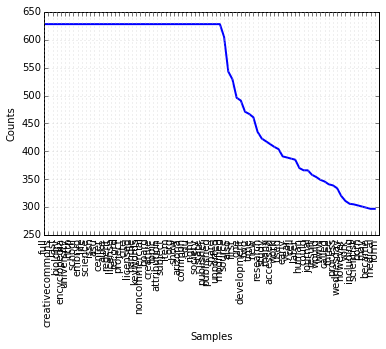

In [9]:
documentcounts.plot(80)

Here we filter the tokens in each document, preserving the shape of the corpus.

In [10]:
filtered_documents = [[token for token in document 
                      if wordcounts[token] < 2000
                      and 1 < documentcounts[token] < 350]
                     for document in documents]

It's easier to compute over integers, so we use a ``Dictionary`` to create a mapping between words and their integer/id representation.

In [11]:
dictionary = gensim.corpora.Dictionary(filtered_documents)

The ``doc2bow()`` converts a document (series of tokens) into a bag-of-words representation.

In [12]:
documents_bow = [dictionary.doc2bow(document) for document in filtered_documents]

We're ready to fit the model! We pass our BOW-transformed documents, our dictionary, and the number of topics. ``update_every=0`` disables an "online" feature in the sampler (used for very very large corpora), and ``passes=20`` tells the sampler to pass over the whole corpus 20 times.

In [14]:
hmodel = gensim.models.HdpModel(documents_bow, id2word=dictionary)

In [29]:
for t in hmodel.show_topics(topics=200, topn=5, formatted=True):
    print t

topic 0: 0.004*gene + 0.004*theory + 0.004*www + 0.004*wilson + 0.004*scientist
topic 1: 0.007*gene + 0.005*dna + 0.004*kammerer + 0.003*egg + 0.003*called
topic 2: 0.008*fistula + 0.007*stem + 0.007*autism + 0.007*hamlin + 0.004*campbell
topic 3: 0.006*child + 0.004*fetus + 0.003*kanner + 0.003*tiedemann + 0.003*baby
topic 4: 0.003*eugenics + 0.003*frog + 0.003*kammerer + 0.003*toad + 0.003*egg
topic 5: 0.009*egg + 0.004*dinosaur + 0.003*system + 0.003*cope + 0.003*death
topic 6: 0.004*abortion + 0.004*thalidomide + 0.003*franklin + 0.003*woman + 0.003*pregnancy
topic 7: 0.005*gene + 0.003*network + 0.003*abortion + 0.003*form + 0.003*protein
topic 8: 0.007*colborn + 0.006*endocrine + 0.005*chemical + 0.003*effect + 0.003*wildlife
topic 9: 0.006*cocaine + 0.004*drug + 0.004*thalidomide + 0.003*born + 0.003*pregnancy
topic 10: 0.016*court + 0.012*preembryos + 0.006*ivf + 0.006*case + 0.006*agreement
topic 11: 0.005*mendel + 0.004*body + 0.003*cuvier + 0.003*anatomy + 0.003*von
topic 12

In [16]:
hdp_documents = hmodel[documents_bow]

In [20]:
hdp_documents[5]

[(0, 0.47440333706986754), (44, 0.52362158604844466)]

## Document graph

In [23]:
import networkx as nx
from collections import Counter
from itertools import combinations

In [25]:
edge_counts = Counter()
node_counts = Counter()
for document in hdp_documents:
    topics, _ = zip(*document)
    for u, v in combinations(topics, 2):
        edge_key = tuple(sorted([u, v]))
        edge_counts[edge_key] += 1.
    for u in topics:
        node_counts[u] += 1.

In [26]:
graph = nx.Graph()
for node, count in node_counts.iteritems():
    graph.add_node(node, weight=count)

for (source, target), count in edge_counts.iteritems():
    graph.add_edge(source, target, weight=count)

In [27]:
graph.order(), graph.size()

(103, 333)

In [34]:
node_labels = {}
for i, topic in hmodel.show_topics(topics=200, topn=5, formatted=False):
    terms = zip(*topic)[0]
    node_labels[i] = ', '.join(terms)

In [35]:
graph = nx.relabel_nodes(graph, node_labels)

In [36]:
nx.write_graphml(graph, 'hdp_graph.graphml')

In [54]:
hmodel.m_Elogbeta.shape, hmodel.m_W

((150, 15115), 15115)

In [81]:
hmodel.m_rhot

0.014925373134328358

In [57]:
from collections import Counter, defaultdict
from itertools import combinations

In [59]:
topic_counts = defaultdict(Counter)
for year, document in zip(years, hdp_documents):
    for topic, representation in document:
        topic_counts[topic][year] += 1.

In [62]:
topics_over_time = pd.DataFrame(columns=['Topic', 'Year', 'Count'])

i = 0
for topic, yearcounts in topic_counts.iteritems():
    for year, count in yearcounts.iteritems():
        topics_over_time.loc[i] = [topic, year, count]
        i += 1

In [67]:
hmodel.show_topics(topn=5)

[u'topic 0: 0.004*gene + 0.004*theory + 0.004*www + 0.004*wilson + 0.004*scientist',
 u'topic 1: 0.007*gene + 0.005*dna + 0.004*kammerer + 0.003*egg + 0.003*called',
 u'topic 2: 0.008*fistula + 0.007*stem + 0.007*autism + 0.007*hamlin + 0.004*campbell',
 u'topic 3: 0.006*child + 0.004*fetus + 0.003*kanner + 0.003*tiedemann + 0.003*baby',
 u'topic 4: 0.003*eugenics + 0.003*frog + 0.003*kammerer + 0.003*toad + 0.003*egg',
 u'topic 5: 0.009*egg + 0.004*dinosaur + 0.003*system + 0.003*cope + 0.003*death',
 u'topic 6: 0.004*abortion + 0.004*thalidomide + 0.003*franklin + 0.003*woman + 0.003*pregnancy',
 u'topic 7: 0.005*gene + 0.003*network + 0.003*abortion + 0.003*form + 0.003*protein',
 u'topic 8: 0.007*colborn + 0.006*endocrine + 0.005*chemical + 0.003*effect + 0.003*wildlife',
 u'topic 9: 0.006*cocaine + 0.004*drug + 0.004*thalidomide + 0.003*born + 0.003*pregnancy',
 u'topic 10: 0.016*court + 0.012*preembryos + 0.006*ivf + 0.006*case + 0.006*agreement',
 u'topic 11: 0.005*mendel + 0.00

In [79]:
topic_1_over_time = topics_over_time[topics_over_time.Topic == 1]

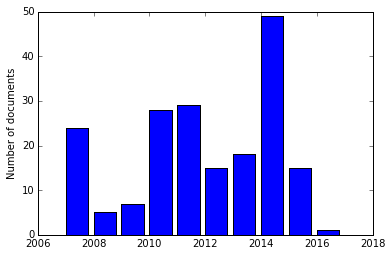

In [80]:
plt.bar(topic_1_over_time.Year, topic_1_over_time.Count)
plt.ylabel('Number of documents')
plt.show()